In [1]:
import glob
import os
import rawpy
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import cv2
import tools
%matplotlib notebook

In [2]:
plot = True
animate = False

In [3]:
RATIO = 0.22
MATCH_RATIO = 0.73
feature_extractor = 'ORB'
matching = 'BF'
BLUR = 0

In [4]:
path = 'kip'
filetypes = ['png', 'tiff', 'jpg']
npy = glob.glob(os.path.join(path, '*.npy'))

slike = []
for filetype in filetypes:
    slike += glob.glob(os.path.join(path, '*.{:s}'.format(filetype)))

#### Priprava slik

In [5]:
if 'grayscale.npy' in [_.split('\\')[-1] for _ in npy]:
    grayscale = np.load(os.path.join(path, 'grayscale.npy'))
else:    
    grayscale = []
    for i, slika in enumerate(slike):
        filetype = slika.split('.')[-1]
        if filetype.lower() in filetypes:
            im = plt.imread(slika)
            if im.ndim == 2:
                image = im
            elif im.ndim == 3:
                bw = cv2.cvtColor(np.uint8(im), cv2.COLOR_BGR2GRAY)
                image = np.uint8(bw)
        if BLUR:
            image = cv2.medianBlur(image, BLUR)
        grayscale.append(image)
                
        print(f'{i+1}/{len(slike)}', end='\r')
    np.save(os.path.join(path, 'grayscale.npy'), np.array(grayscale))

In [6]:
if animate:
    sequence = grayscale
    fig = plt.figure()
    im = plt.imshow(sequence[0], cmap='gray', interpolation='nearest', animated=True) # starting image

    def updatefig(i):
        im.set_array(sequence[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=len(sequence), interval=200, blit=False)
    plt.show()

In [7]:
slika1 = cv2.resize(grayscale[0], dsize=(0, 0), fx=RATIO, fy=RATIO)
slika2 = cv2.resize(grayscale[1], dsize=(0, 0), fx=RATIO, fy=RATIO)

<IPython.core.display.Javascript object>


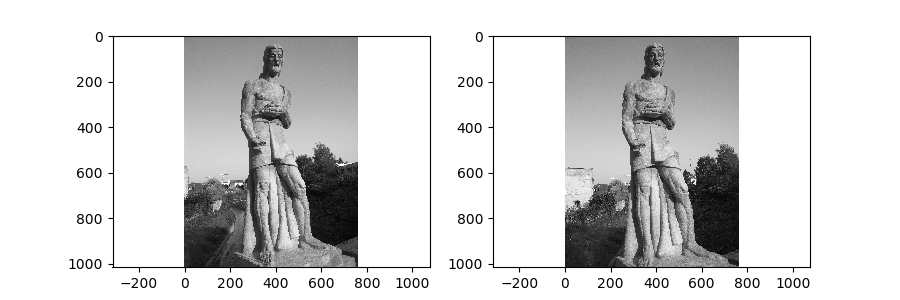

In [8]:
if plot:
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(9,3))
    ax1.imshow(slika1, cmap='gray')
    ax2.imshow(slika2, cmap='gray')
    ax1.axis('equal')
    ax2.axis('equal')

#### Feature Extraction (ORB)

[Oriented FAST and Rotated BRIEF](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html#orb)

In [9]:
if feature_extractor == 'ORB':
    descriptor = cv2.ORB_create(10000)
elif feature_extractor == 'SIFT':
    descriptor = cv2.xfeatures2d.SIFT_create(5000)
else:
    raise Exception('Select a valid feature extractor/descriptor algorithm.')
    
# find the keypoints and descriptors
kp1, des1 = descriptor.detectAndCompute(slika1, mask=None)
kp2, des2 = descriptor.detectAndCompute(slika2, mask=None)
print(len(kp1))

8362


In [10]:
out = np.zeros_like(slika1, dtype=np.uint8)
showkp1 = cv2.drawKeypoints(slika1, kp1, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
showkp2 = cv2.drawKeypoints(slika2, kp2, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

<IPython.core.display.Javascript object>


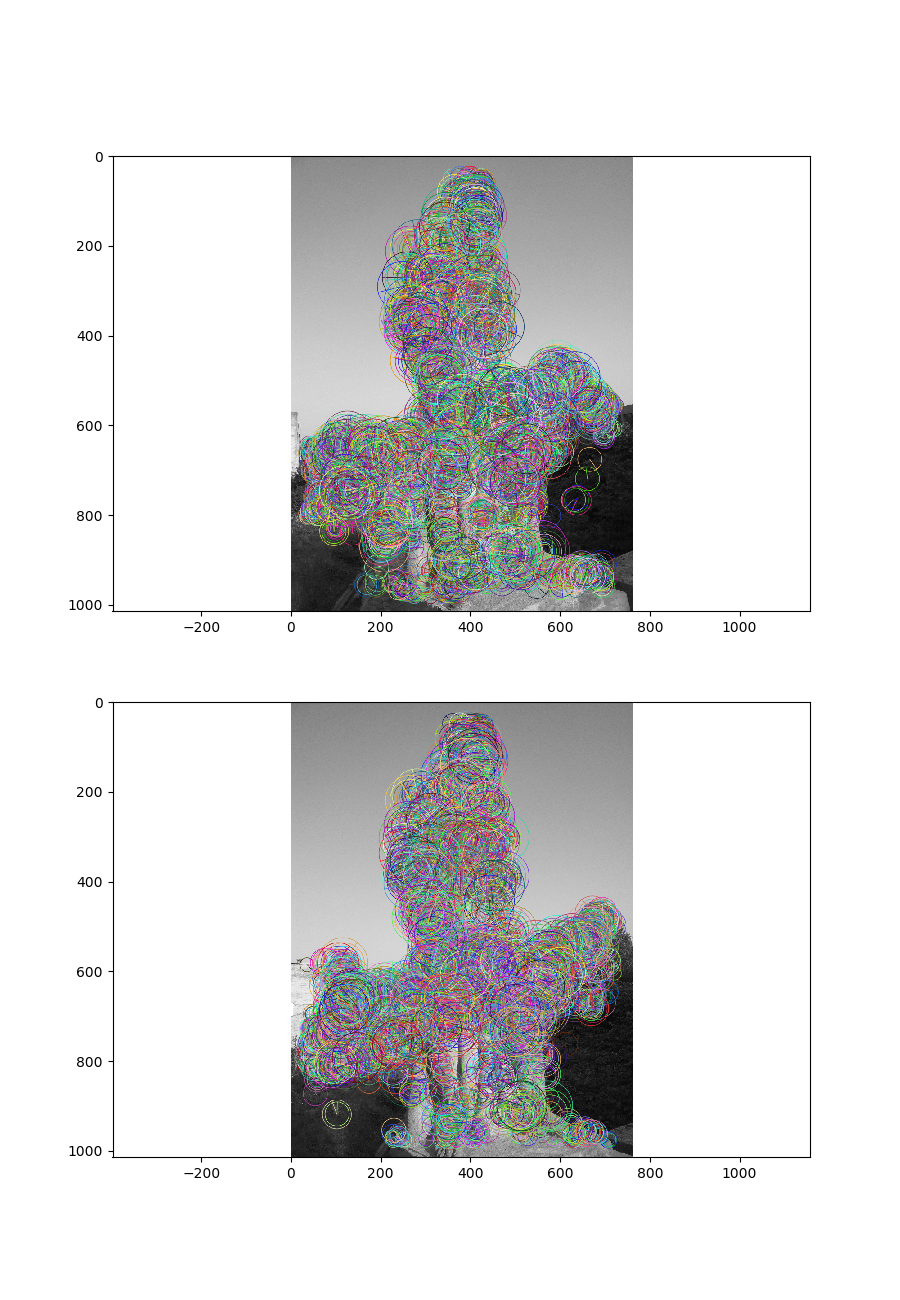

In [11]:
if plot:
    fig, [ax1, ax2] = plt.subplots(2,1,figsize=(9,13))
    ax1.imshow(showkp1)
    ax2.imshow(showkp2)
    ax1.axis('equal')
    ax2.axis('equal')

#### Feature Matching (FLANN)

[Fast Library for Approximate Nearest Neighbors](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

In [12]:
if feature_extractor == 'ORB':
    if matching == 'BF':
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    else:
        FLANN_INDEX_LSH = 6
        index_params= dict(algorithm = FLANN_INDEX_LSH,
                           table_number = 12, # 12
                           key_size = 16,     # 20
                           multi_probe_level = 2) #2
        search_params = dict(checks=150)

        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        
elif feature_extractor == 'SIFT':
    if matching == 'BF':        
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:
        FLANN_INDEX_LSH = 0 # SIFT
        index_params= dict(algorithm = FLANN_INDEX_LSH,
                           trees = 5)
        search_params = dict(checks=100)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)

matches = matcher.knnMatch(des1, des2, k=2)

Only use good matches:

In [13]:
good = []
t1 = []
t2 = []
matchesMask = [[0,0] for i in range(len(matches))]
for i,(m,n) in enumerate(matches):
    if m.distance < MATCH_RATIO*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)
        t2.append(kp2[m.trainIdx].pt)
        t1.append(kp1[m.queryIdx].pt)
len(good)

1739

In [14]:
i1 = good[0].queryIdx
i2 = good[0].trainIdx
tocke1 = np.array([k.pt for k in kp1])

In [15]:
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask,
                   flags = 0)

matches_image = cv2.drawMatchesKnn(slika1,kp1,slika2,kp2,matches,None,**draw_params)

<IPython.core.display.Javascript object>


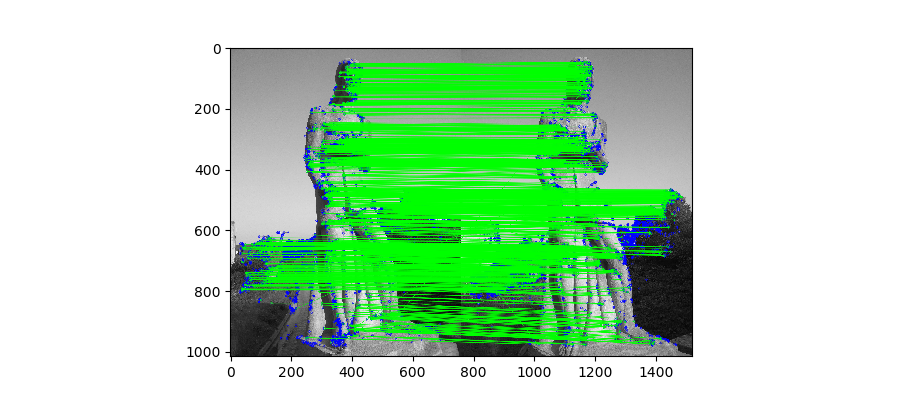

In [16]:
if plot:
    plt.figure(figsize=(9, 4))
    plt.imshow(matches_image)
    plt.show()
#cv2.imwrite('feature_matches.jpg', matches_image)

#### Compute the Fundamental Matrix
<a href="http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#Mat%20findFundamentalMat(InputArray%20points1,%20InputArray%20points2,%20int%20method,%20double%20param1,%20double%20param2,%20OutputArray%20mask)">cv2.findFundamentalMat</a>

In [17]:
def fun_mat_8point(p1, p2, K=None):
    """
    p1: (x ,y) coordinates of points in first image
    p2: (x ,y) coordinates of points in second image
    H & Z, p. 279
    """
    
    if K is not None:
        inv_K = np.linalg.inv(K)
        p1_ = np.column_stack((p1, np.ones_like(p1[:, 0]))).T
        p2_ = np.column_stack((p2, np.ones_like(p2[:, 0]))).T
        p1 = np.dot(inv_K, p1_).T[:, :2]
        p2 = np.dot(inv_K, p2_).T[:, :2]

    
    x1 = p1[:, 0]
    y1 = p1[:, 1]
    x2 = p2[:, 0]
    y2 = p2[:, 1]
    
    c1 = x2 * x1
    c2 = x2 * y1
    c3 = x2
    c4 = y2 * x1
    c5 = y2 * y1
    c6 = y2
    c7 = x1
    c8 = y1
    c9 = np.ones_like(c1)
    A = np.column_stack((c1, c2, c3, c4, c5, c6, c7, c8, c9))
    U, D, V = np.linalg.svd(A)
    f = V[-1]
    F = f.reshape(3, 3)
    u, d, v = np.linalg.svd(F)
    d_singular = np.diag(np.array([d[0], d[1], 0], dtype=float))
    F = u.dot(d_singular).dot(v)
    
    if K is not None:
        F = np.dot(inv_K.T, F).dot(inv_K)
    
    return F

In [18]:
path_calib = 'kalibracija/redmi'
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)

In [19]:
p1 = np.array(t1, dtype=np.int32)
p2 = np.array(t2, dtype=np.int32)
F, mask = cv2.findFundamentalMat(p1, p2, cv2.FM_RANSAC, 0.2, 0.995)

In [20]:
p1 = p1[mask.ravel()==1]
p2 = p2[mask.ravel()==1]
len(p1)

271

In [21]:
F1 = fun_mat_8point(p1.astype(float), p2.astype(float), K)

In [22]:
inv_K = np.linalg.inv(K)
p1_ = np.column_stack((p1, np.ones_like(p1[:, 0]))).T
p2_ = np.column_stack((p2, np.ones_like(p2[:, 0]))).T
p1_ = np.dot(inv_K, p1_).T[:, :2]
p2_ = np.dot(inv_K, p2_).T[:, :2]
F, mask = cv2.findFundamentalMat(p1_, p2_, cv2.FM_8POINT)
F = np.dot(inv_K.T, F).dot(inv_K)

In [23]:
F1

array([[  1.39542143e-09,  -4.19697519e-08,   1.74393800e-05],
       [  5.52598031e-08,   2.66685362e-09,  -1.14838278e-04],
       [ -2.74845510e-05,   1.10317784e-04,   3.09901795e-03]])

In [24]:
F

array([[  2.59081292e-08,  -8.44213282e-07,   3.50406275e-04],
       [  1.11561230e-06,   5.40542800e-08,  -2.33473012e-03],
       [ -5.52602654e-04,   2.24056417e-03,   7.13669945e-02]])

Draw the epilines:

In [25]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

<IPython.core.display.Javascript object>


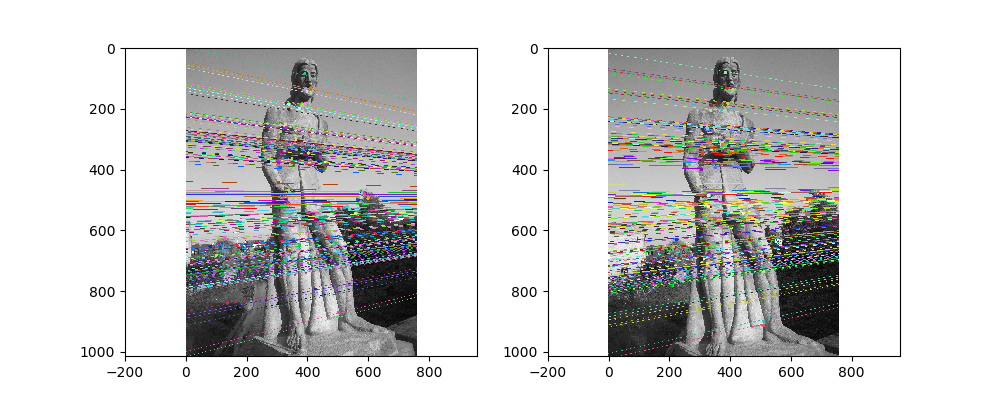

In [26]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(p2.reshape(-1,1,2), 2, F1)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(slika1, slika2, lines1, p1, p2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(p1.reshape(-1,1,2), 1, F1)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(slika2, slika1, lines2, p2, p1)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10, 4))
ax1.imshow(img5)
ax2.imshow(img3)
ax1.axis('equal')
ax2.axis('equal')
plt.show()

[epilines not correct discussion](http://answers.opencv.org/question/18125/epilines-not-correct/)

In [27]:
def F_error(p1, p2, F):
    p2_ = np.column_stack((p2, np.ones(p2.shape[0])))
    p1_ = np.column_stack((p1, np.ones(p1.shape[0]))).T
    mat = np.dot(p2_, F).dot(p1_)
    return np.sum(np.diag(mat) ** 2)

In [28]:
F_error(p1, p2, F)

1.351727659283252e-05